In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, average_precision_score, confusion_matrix
import xgboost as xgb
from sklearn.model_selection import StratifiedKFold
from imblearn.under_sampling import RandomUnderSampler
# from paper_zeeg_utils import *
from paper_zeeg_utils import map_nan_index
import joblib
import shap
import mne
from lightgbm import LGBMClassifier
# from sklearn.ensemble import RandomForestClassifier

In [3]:
mtl_path = 'C:\\clean_zeeg\\P%s_mtl_clean.fif'
tlv_subjects = ['013', '017', '018', '025', '38', '39', '44', '46', '47', '48', '49', '51', '53', '54', '55', '56', '57']
bonn_subjects = ['707', '708', '709', '710', '711', '712', '713', '714', '715', '723', '724', '728', '731', '733', '734', '735', '737', '744', '746', '752']
milan_subjects = ['801', '802', '804', '805', '807', '809', '810', '812', '813', '814', '815', '816', '817', '818']
all_subjects = tlv_subjects + bonn_subjects + milan_subjects
depth_channels = ['RAH1', 'LAH1', 'RA1', 'LA1', 'LEC1', 'REC1', 'RPHG1', 'LPHG1', 'RMH1', 'LMH1', 'LH1', 'RH1', 'RA3'
                  'RAH2', 'LAH2', 'RA2', 'LA2', 'LEC2', 'REC2', 'RPHG2', 'LPHG2', 'RMH2', 'LMH2', 'LH2', 'RH2']
scalp_channels = ['C3', 'C4', 'PZ', 'EOG1', 'EOG2', 'F4', 'P4', 'F10', 'T10', 'F3', 'P3', 'F9', 'T9', 'CZ', 'P4', 'F8',
                  'T8', 'P8', 'O1', 'O2', 'T5', 'C6', 'P6', 'F7', 'C5', 'P5', 'FZ']

In [4]:
# load dict with all relevant data per subject
subj_data = joblib.load('subj_data_final.pkl')
subj_data_yb = joblib.load('subj_data_final_yb.pkl')

In [71]:
bad_under_55 = ['39', '55', '801', '802', '805', '809', '812', '813', '815', '816', '817']
less_4_chans = ['018', '025', '46', '53', '801', '809', '814', '818']
less_10 = ['025', '46', '49', '807', '814']
# clean_subjects = [x for x in all_subjects if x not in bad_under_55+less_10]
clean_subjects = [x for x in tlv_subjects+bonn_subjects if x not in bad_under_55+less_10]
# clean_subjects = all_subjects
print(len(all_subjects), len(clean_subjects))

51 32


In [83]:
# combine all subjects
symmetric = True
x = pd.DataFrame()
y = np.array([])
for subj in clean_subjects:
    print(f'Processing {subj}')
    eog1_subj = subj_data[subj]['eog1']
    eog2_subj = subj_data[subj]['eog2']
    y_subj = subj_data[subj]['y']
    eog1_subj.reset_index(drop=True, inplace=True)
    eog2_subj.reset_index(drop=True, inplace=True)
    x_subj = pd.concat([eog1_subj, eog2_subj], axis=1, ignore_index=True)
    x_subj.columns = [f'eog1_{col}' for col in eog1_subj.columns] + [f'eog2_{col}' for col in eog2_subj.columns]
    x = pd.concat([x, x_subj], ignore_index=True)
    if symmetric:
        x_sym = pd.concat([eog2_subj, eog1_subj], axis=1, ignore_index=True)
        x_sym.columns = x_subj.columns
        x = pd.concat([x, x_sym], ignore_index=True)
        y = np.concatenate((y, y_subj))
    y = np.concatenate((y, y_subj))

Processing 013
Processing 017
Processing 018
Processing 38
Processing 44
Processing 47
Processing 48
Processing 51
Processing 53
Processing 54
Processing 56
Processing 57
Processing 707
Processing 708
Processing 709
Processing 710
Processing 711
Processing 712
Processing 713
Processing 714
Processing 715
Processing 723
Processing 724
Processing 728
Processing 731
Processing 733
Processing 734
Processing 735
Processing 737
Processing 744
Processing 746
Processing 752


In [84]:
# print ratio of spikes
sum(y) / len(y)

0.025809523783474935

In [347]:
# undersample
rus = RandomUnderSampler(random_state=8)
x, y = rus.fit_resample(x, y)

In [ ]:
# replicate thesis ratio
x['pred'] = y
sampled_data_0 = pd.DataFrame()
sampled_data_1 = pd.DataFrame()
max_samples = 7000

for subj in clean_subjects:
    n_spikes = x[(x['eog1_subj'] == subj) & (x['pred'] == 1)].shape[0]
    print(subj, n_spikes)
    
    # Calculate the number of samples for each class based on the ratio
    sample_count_1 = min(max_samples, n_spikes)
    sample_count_0 = sample_count_1 * 40
    
    sampled_data_0 = pd.concat([sampled_data_0, x[(x['eog1_subj'] == subj) & (x['pred'] == 0)].sample(int(sample_count_0), replace=True, random_state=8)])
    sampled_data_1 = pd.concat([sampled_data_1, x[(x['eog1_subj'] == subj) & (x['pred'] == 1)].sample(int(sample_count_1), replace=True, random_state=8)])

# Combine the sampled data
sampled_data = pd.concat([sampled_data_1, sampled_data_0], ignore_index=True)
x = sampled_data.drop(columns='pred')
y = sampled_data['pred']
print(sum(y) / len(y))

In [85]:
# balance data
x['pred'] = y
sampled_data_0 = pd.DataFrame()
sampled_data_1 = pd.DataFrame()
max_samples = 6000
for subj in clean_subjects:
    n_spikes = x[(x['eog1_subj'] == subj) & (x['pred'] == 1)].shape[0]
    print(subj, n_spikes)
    sample_count = min(max_samples, n_spikes)
    sampled_data_0 = pd.concat([sampled_data_0, x[(x['eog1_subj'] == subj) & (x['pred'] == 0)].sample(sample_count, replace=True, random_state=8)])
    sampled_data_1 = pd.concat([sampled_data_1, x[(x['eog1_subj'] == subj) & (x['pred'] == 1)].sample(sample_count, replace=True, random_state=8)])

sampled_data = pd.concat([sampled_data_1, sampled_data_0], ignore_index=True)
x = sampled_data.drop(columns='pred')
y = sampled_data['pred']
sampled_data

013 1720
017 2128
018 124
38 2116
44 2262
47 194
48 680
51 1966
53 988
54 2044
56 2430
57 2752
707 1916
708 15740
709 6488
710 1982
711 5994
712 1276
713 26046
714 10930
715 4856
723 6664
724 1500
728 15698
731 20120
733 13660
734 2790
735 8184
737 772
744 8252
746 9892
752 6562


,eog1_subj,eog1_epoch_id,eog1_app_entropy,eog1_decorr_time,eog1_energy_freq_bands_theta,eog1_energy_freq_bands_alpha,eog1_energy_freq_bands_sigma,eog1_energy_freq_bands_beta,eog1_energy_freq_bands_gamma,eog1_energy_freq_bands_fast,...,eog2_energy_freq_bands_sg,eog2_energy_freq_bands_sf,eog2_energy_freq_bands_gt,eog2_energy_freq_bands_gf,eog2_energy_freq_bands_ft,eog2_chan_name,eog2_chan_ptp,eog2_chan_skew,eog2_chan_kurt,pred
0,013,59494,0.129083,-1.000,0.600729,1.069837,1.843881,0.644323,0.067834,0.001486,...,17.117715,357.734478,0.324458,20.898495,0.015525,EOG2,42.421705,-0.435746,18.247598,1.0
1,013,62728,0.086768,-1.000,0.036895,0.223648,0.945054,0.715200,0.066430,0.004593,...,3.037991,844.824529,2.083712,278.086589,0.007493,EOG1,56.238462,-0.031135,11.269391,1.0
2,013,51457,0.272832,-1.000,0.055827,0.318945,0.259579,0.929908,0.240906,0.002576,...,1.984866,33.880880,1.326272,17.069605,0.077698,EOG2,42.421705,-0.435746,18.247598,1.0
3,013,15829,0.115442,0.041,0.420092,1.647496,0.528142,0.153927,0.153231,0.002798,...,10.277092,157.784805,0.578813,15.353059,0.037700,EOG2,42.421705,-0.435746,18.247598,1.0
4,013,15339,0.155859,0.038,0.695643,0.998246,0.621330,0.714989,0.068186,0.004202,...,7.224875,283.499621,0.192116,39.239379,0.004896,EOG1,56.238462,-0.031135,11.269391,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
224975,752,62638,0.328282,0.038,0.010792,0.530439,0.546115,0.958093,1.114280,0.001550,...,0.053756,22.195365,29.422017,412.893659,0.071258,EOG1,37.266089,-1.051296,20.886734,0.0
224976,752,16182,0.274680,0.026,0.139033,0.059468,0.290918,0.732256,0.584074,0.000498,...,4.200193,423.855160,0.882789,100.913253,0.008748,EOG1,37.266089,-1.051296,20.886734,0.0
224977,752,86441,0.164358,0.028,0.177213,0.046806,0.191378,0.321445,0.291243,0.001373,...,0.764595,123.415094,0.786889,161.412313,0.004875,EOG2,41.934944,-0.717236,13.941126,0.0
224978,752,10614,0.244809,0.024,1.291339,0.374471,1.756735,4.040828,1.198320,0.007118,...,1.834793,268.684119,0.893728,146.438397,0.006103,EOG1,37.266089,-1.051296,20.886734,0.0


In [193]:
# 90-10
x['pred'] = y
sampled_data_0 = pd.DataFrame()
sampled_data_1 = pd.DataFrame()
max_samples = 6000
ratio_0 = 0.9  # Desired ratio for class 0
ratio_1 = 0.1  # Desired ratio for class 1

for subj in clean_subjects:
    n_spikes = x[(x['eog1_subj'] == subj) & (x['pred'] == 1)].shape[0]
    print(subj, n_spikes)
    
    # Calculate the number of samples for each class based on the ratio
    sample_count_1 = min(max_samples, n_spikes)
    sample_count_0 = sample_count_1 * 9
    
    sampled_data_0 = pd.concat([sampled_data_0, x[(x['eog1_subj'] == subj) & (x['pred'] == 0)].sample(int(sample_count_0), replace=True, random_state=8)])
    sampled_data_1 = pd.concat([sampled_data_1, x[(x['eog1_subj'] == subj) & (x['pred'] == 1)].sample(int(sample_count_1), replace=True, random_state=8)])

# Combine the sampled data
sampled_data = pd.concat([sampled_data_1, sampled_data_0], ignore_index=True)
x = sampled_data.drop(columns='pred')
y = sampled_data['pred']
sampled_data

013 9054
017 6830
018 450
025 260
38 23334
39 13626
44 8178
46 732
47 2290
48 2400
49 16
51 7592
53 3674
54 12756
55 10598
56 9270
57 6654
707 10932
708 56024
709 14514
710 11492
711 25450
712 5518
713 92666
714 38018
715 22154
723 44666
724 35802
728 75804
731 64802
733 91768
734 29652
735 74378
737 38226
744 58016
746 37308
752 22080
801 13588
802 12268
804 23560
805 19556
807 0
809 7900
810 5970
812 12302
813 7202
814 556
815 10454
816 40682
817 8936
818 24228


,eog1_subj,eog1_epoch_id,eog1_app_entropy,eog1_decorr_time,eog1_energy_freq_bands_theta,eog1_energy_freq_bands_alpha,eog1_energy_freq_bands_sigma,eog1_energy_freq_bands_beta,eog1_energy_freq_bands_gamma,eog1_energy_freq_bands_fast,...,eog2_energy_freq_bands_sg,eog2_energy_freq_bands_sf,eog2_energy_freq_bands_gt,eog2_energy_freq_bands_gf,eog2_energy_freq_bands_ft,eog2_chan_name,eog2_chan_ptp,eog2_chan_skew,eog2_chan_kurt,pred
0,013,2250,0.462852,0.017,0.020600,0.049852,0.084322,0.657140,1.090484,0.003691,...,0.178444,32.177657,12.462120,180.323077,0.069110,EOG1,56.238462,-0.031135,11.269391,1.0
1,013,58895,0.236813,0.039,0.139538,0.137374,0.033055,0.092707,0.088106,0.002356,...,0.224241,5.202870,1.833693,23.202129,0.079031,EOG2,42.421705,-0.435746,18.247598,1.0
2,013,60166,0.144734,0.028,0.794101,0.950946,2.190323,1.555162,0.274506,0.001829,...,18.163915,452.950863,0.215586,24.936852,0.008645,EOG2,42.421705,-0.435746,18.247598,1.0
3,013,63067,0.221044,0.025,0.064930,0.229482,0.169491,0.073148,0.012786,0.004095,...,1.756350,46.287385,0.698616,26.354313,0.026509,EOG1,56.238462,-0.031135,11.269391,1.0
4,013,39358,0.073349,-1.000,0.034535,0.010574,0.034720,0.065313,0.126498,0.003045,...,0.141278,19.664171,0.945322,139.188024,0.006792,EOG1,56.238462,-0.031135,11.269391,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2618655,818,59129,0.460435,0.025,0.001056,0.023749,0.060693,0.048438,0.053299,0.135499,...,1.138723,0.447924,50.449661,0.393357,128.254279,EOG,66.780052,-2.357676,62.573109,0.0
2618656,818,28884,0.424851,-1.000,0.016412,0.012866,0.011753,0.008732,0.054980,0.095350,...,0.213764,0.123259,3.349895,0.576613,5.809606,EOG,66.780052,-2.357676,62.573109,0.0
2618657,818,97657,0.443850,0.045,0.006835,0.017967,0.023256,0.020958,0.045003,0.111561,...,0.516777,0.208462,6.584509,0.403390,16.322951,EOG,66.780052,-2.357676,62.573109,0.0
2618658,818,59025,0.890351,0.027,0.018078,0.009024,0.005450,0.008030,0.037176,0.110364,...,0.146601,0.049382,2.056359,0.336846,6.104740,EOG,66.780052,-2.357676,62.573109,0.0


In [86]:
meta_data = ['subj', 'epoch_id', 'chan_name', 'epoch']
x_feat = x[x.columns[~x.columns.str.contains('|'.join(meta_data))]]

x_feat

,eog1_app_entropy,eog1_decorr_time,eog1_energy_freq_bands_theta,eog1_energy_freq_bands_alpha,eog1_energy_freq_bands_sigma,eog1_energy_freq_bands_beta,eog1_energy_freq_bands_gamma,eog1_energy_freq_bands_fast,eog1_higuchi_fd,eog1_hjorth_complexity,...,eog2_energy_freq_bands_bf,eog2_energy_freq_bands_st,eog2_energy_freq_bands_sg,eog2_energy_freq_bands_sf,eog2_energy_freq_bands_gt,eog2_energy_freq_bands_gf,eog2_energy_freq_bands_ft,eog2_chan_ptp,eog2_chan_skew,eog2_chan_kurt
0,0.129083,-1.000,0.600729,1.069837,1.843881,0.644323,0.067834,0.001486,1.003085,11.318929,...,89.960637,5.553981,17.117715,357.734478,0.324458,20.898495,0.015525,42.421705,-0.435746,18.247598
1,0.086768,-1.000,0.036895,0.223648,0.945054,0.715200,0.066430,0.004593,1.055103,12.539048,...,804.361396,6.330299,3.037991,844.824529,2.083712,278.086589,0.007493,56.238462,-0.031135,11.269391
2,0.272832,-1.000,0.055827,0.318945,0.259579,0.929908,0.240906,0.002576,1.050595,6.632653,...,120.812347,2.632472,1.984866,33.880880,1.326272,17.069605,0.077698,42.421705,-0.435746,18.247598
3,0.115442,0.041,0.420092,1.647496,0.528142,0.153927,0.153231,0.002798,1.039079,16.828795,...,23.047816,5.948514,10.277092,157.784805,0.578813,15.353059,0.037700,42.421705,-0.435746,18.247598
4,0.155859,0.038,0.695643,0.998246,0.621330,0.714989,0.068186,0.004202,1.034761,12.680685,...,309.353448,1.388014,7.224875,283.499621,0.192116,39.239379,0.004896,56.238462,-0.031135,11.269391
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
224975,0.328282,0.038,0.010792,0.530439,0.546115,0.958093,1.114280,0.001550,1.050254,6.483458,...,241.075278,1.581600,0.053756,22.195365,29.422017,412.893659,0.071258,37.266089,-1.051296,20.886734
224976,0.274680,0.026,0.139033,0.059468,0.290918,0.732256,0.584074,0.000498,1.042570,5.382058,...,373.665655,3.707883,4.200193,423.855160,0.882789,100.913253,0.008748,37.266089,-1.051296,20.886734
224977,0.164358,0.028,0.177213,0.046806,0.191378,0.321445,0.291243,0.001373,1.058044,13.338177,...,160.126006,0.601652,0.764595,123.415094,0.786889,161.412313,0.004875,41.934944,-0.717236,13.941126
224978,0.244809,0.024,1.291339,0.374471,1.756735,4.040828,1.198320,0.007118,1.071973,4.885550,...,460.244623,1.639806,1.834793,268.684119,0.893728,146.438397,0.006103,37.266089,-1.051296,20.886734


In [91]:
# permutation > 0.001
new_feat1 = ["chan_kurt", "chan_ptp", "chan_skew", "energy_freq_bands_gamma","teager_kaiser_energy_1_std","energy_freq_bands_beta","samp_entropy","ptp_amp","mean","teager_kaiser_energy_0_mean","line_length","teager_kaiser_energy_0_std","teager_kaiser_energy_5_std","teager_kaiser_energy_2_std","energy_freq_bands_alpha","spect_slope_intercept","higuchi_fd","quantile","pow_freq_bands_fast/alpha","energy_freq_bands_sigma","energy_freq_bands_bg", "energy_freq_bands_gf"]
# model importance > 20
new_feat2 = ["chan_kurt","chan_ptp","chan_skew","energy_freq_bands_gamma","energy_freq_bands_beta","energy_freq_bands_bg","samp_entropy","line_length","teager_kaiser_energy_1_std","skewness","mean","teager_kaiser_energy_0_mean","energy_freq_bands_sigma","spect_slope_slope","teager_kaiser_energy_2_std","ptp_amp","quantile","teager_kaiser_energy_0_std","energy_freq_bands_gf","std","higuchi_fd","pow_freq_bands_gamma/beta", "rms"]
common_features = ['eog1_'+ x for x in list(set(new_feat1) & set(new_feat2))] + ['eog2_'+ x for x in list(set(new_feat1) & set(new_feat2))]
x_feat = x[x.columns[x.columns.isin(common_features)]]
x_feat

,eog1_energy_freq_bands_sigma,eog1_energy_freq_bands_beta,eog1_energy_freq_bands_gamma,eog1_higuchi_fd,eog1_line_length,eog1_mean,eog1_ptp_amp,eog1_quantile,eog1_samp_entropy,eog1_teager_kaiser_energy_0_mean,...,eog2_samp_entropy,eog2_teager_kaiser_energy_0_mean,eog2_teager_kaiser_energy_0_std,eog2_teager_kaiser_energy_1_std,eog2_teager_kaiser_energy_2_std,eog2_energy_freq_bands_bg,eog2_energy_freq_bands_gf,eog2_chan_ptp,eog2_chan_skew,eog2_chan_kurt
0,1.843881,0.644323,0.067834,1.003085,0.042402,-0.097312,5.139200,0.623152,0.077328,24.811702,...,0.095280,6.952122,28.649761,0.372428,0.032508,4.304647,20.898495,42.421705,-0.435746,18.247598
1,0.945054,0.715200,0.066430,1.055103,0.030835,0.140161,4.031815,0.910711,0.084454,5.968294,...,0.094347,10.065937,30.752470,3.047655,0.076533,2.892485,278.086589,56.238462,-0.031135,11.269391
2,0.259579,0.929908,0.240906,1.050595,0.031351,-0.061611,1.860520,0.279996,0.257864,4.600831,...,0.290600,1.792966,4.151575,0.535359,0.030772,7.077630,17.069605,42.421705,-0.435746,18.247598
3,0.528142,0.153927,0.153231,1.039079,0.038954,0.005810,4.104855,0.624778,0.074952,31.397614,...,0.116546,9.238864,18.645034,0.479414,0.017360,1.501187,15.353059,42.421705,-0.435746,18.247598
4,0.621330,0.714989,0.068186,1.034761,0.034742,0.885696,3.067685,1.070669,0.124085,8.324112,...,0.148399,14.174361,77.895109,5.187258,0.178402,7.883750,39.239379,56.238462,-0.031135,11.269391
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
224975,0.546115,0.958093,1.114280,1.050254,0.036804,0.191304,2.151883,0.456942,0.283138,2.717981,...,0.323518,1.730166,4.875089,0.309344,0.255799,0.583868,412.893659,37.266089,-1.051296,20.886734
224976,0.290918,0.732256,0.584074,1.042570,0.029249,0.048455,1.904294,0.326266,0.225665,3.094689,...,0.215254,2.143545,4.644174,0.557302,0.034037,3.702840,100.913253,37.266089,-1.051296,20.886734
224977,0.191378,0.321445,0.291243,1.058044,0.026705,0.461780,2.507817,0.900890,0.172429,4.071947,...,0.194263,7.735495,17.995985,0.656115,0.059673,0.992031,161.412313,41.934944,-0.717236,13.941126
224978,1.756735,4.040828,1.198320,1.071973,0.053215,0.432819,4.184899,0.779606,0.164442,18.247852,...,0.237014,10.904012,19.163207,6.924529,0.186960,3.142923,146.438397,37.266089,-1.051296,20.886734


In [94]:
# top x intesection
features = ['chan_kurt',
 'chan_ptp',
 'chan_skew',
 'energy_freq_bands_gamma',
 'teager_kaiser_energy_1_std',
 'energy_freq_bands_beta',
 'samp_entropy',
 'ptp_amp',
 'energy_freq_bands_bg',
 'mean',
 'energy_freq_bands_alpha',
 'energy_freq_bands_sigma',
 'energy_freq_bands_gf',
 'quantile',
 'teager_kaiser_energy_0_mean',
 'line_length',
 'teager_kaiser_energy_0_std',
 'teager_kaiser_energy_5_std',
 'teager_kaiser_energy_2_std',
 'spect_slope_intercept',
 'higuchi_fd',
 'skewness',
 'energy_freq_bands_sg',
 'hurst_exp',
 'teager_kaiser_energy_2_mean',
 'teager_kaiser_energy_3_std',
 'energy_freq_bands_fast',
 'hjorth_mobility',
 'energy_freq_bands_ab',
 'pow_freq_bands_gamma/beta',
 'svd_entropy',
 'energy_freq_bands_theta',
 'energy_freq_bands_bf',
 'energy_freq_bands_gt',
 'rms',
 'energy_freq_bands_ag']
common_features = ['eog1_'+ x for x in features] + ['eog2_'+ x for x in features]
x_feat = x[x.columns[x.columns.isin(common_features)]]
x_feat

,eog1_energy_freq_bands_theta,eog1_energy_freq_bands_alpha,eog1_energy_freq_bands_sigma,eog1_energy_freq_bands_beta,eog1_energy_freq_bands_gamma,eog1_energy_freq_bands_fast,eog1_higuchi_fd,eog1_hjorth_mobility,eog1_hurst_exp,eog1_line_length,...,eog2_energy_freq_bands_ab,eog2_energy_freq_bands_ag,eog2_energy_freq_bands_bg,eog2_energy_freq_bands_bf,eog2_energy_freq_bands_sg,eog2_energy_freq_bands_gt,eog2_energy_freq_bands_gf,eog2_chan_ptp,eog2_chan_skew,eog2_chan_kurt
0,0.600729,1.069837,1.843881,0.644323,0.067834,0.001486,1.003085,0.045677,-1.441918,0.042402,...,2.838964,12.220736,4.304647,89.960637,17.117715,0.324458,20.898495,42.421705,-0.435746,18.247598
1,0.036895,0.223648,0.945054,0.715200,0.066430,0.004593,1.055103,0.105398,0.649364,0.030835,...,0.327603,0.947586,2.892485,804.361396,3.037991,2.083712,278.086589,56.238462,-0.031135,11.269391
2,0.055827,0.318945,0.259579,0.929908,0.240906,0.002576,1.050595,0.077001,0.539351,0.031351,...,0.199450,1.411637,7.077630,120.812347,1.984866,1.326272,17.069605,42.421705,-0.435746,18.247598
3,0.420092,1.647496,0.528142,0.153927,0.153231,0.002798,1.039079,0.065680,1.013224,0.038954,...,13.665931,20.515121,1.501187,23.047816,10.277092,0.578813,15.353059,42.421705,-0.435746,18.247598
4,0.695643,0.998246,0.621330,0.714989,0.068186,0.004202,1.034761,0.068664,0.816348,0.034742,...,1.357750,10.704165,7.883750,309.353448,7.224875,0.192116,39.239379,56.238462,-0.031135,11.269391
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
224975,0.010792,0.530439,0.546115,0.958093,1.114280,0.001550,1.050254,0.116365,0.373729,0.036804,...,0.204190,0.119220,0.583868,241.075278,0.053756,29.422017,412.893659,37.266089,-1.051296,20.886734
224976,0.139033,0.059468,0.290918,0.732256,0.584074,0.000498,1.042570,0.078684,0.519834,0.029249,...,0.801177,2.966632,3.702840,373.665655,4.200193,0.882789,100.913253,37.266089,-1.051296,20.886734
224977,0.177213,0.046806,0.191378,0.321445,0.291243,0.001373,1.058044,0.070432,0.580424,0.026705,...,0.579154,0.574538,0.992031,160.126006,0.764595,0.786889,161.412313,41.934944,-0.717236,13.941126
224978,1.291339,0.374471,1.756735,4.040828,1.198320,0.007118,1.071973,0.086408,0.711146,0.053215,...,0.162551,0.510886,3.142923,460.244623,1.834793,0.893728,146.438397,37.266089,-1.051296,20.886734


In [95]:
# save models
n_s = x['eog1_subj'].nunique()
n_f = x_feat.shape[1]
n_max = 'nomax' if max_samples > 30000 else f'{max_samples}max'
balance = 'b' if sum(y) / len(y) == 0.5 else 'ub'
name = f's{n_s}_f{n_f}_{balance}_{n_max}'
name

's32_f72_b_6000max'

In [96]:
from datetime import datetime
print(datetime.now())
# model = LGBMClassifier()
# model.fit(x_feat, y)
# joblib.dump(model, f'../validation_models_v3/lgbm_{name}.pkl')
# print(datetime.now())
# model = RandomForestClassifier()
# model.fit(x_feat, y)
# joblib.dump(model, f'../validation_models_v3/rf_{name}.pkl')
# print(datetime.now())
model = xgb.XGBClassifier()
model.fit(x_feat, y)
joblib.dump(model, f'../validation_models_v3/xgb_{name}.pkl')

2024-12-12 12:21:32.173843


['../validation_models_v3/xgb_s32_f72_b_6000max.pkl']

In [97]:
print('done')

done


In [411]:

metrics = {'accuracy': [], 'precision': [], 'sensitivity': [], 'specificity': [],'f1': [], 'ROCAUC': [], 'PRAUC': []}
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=8)
i = 1
for train_index, test_index in kf.split(x_feat, y):
    print(f'Fold {i}')
    i += 1
    model = xgb.XGBClassifier()
    #model = LGBMClassifier()
    x_train_fold, x_test_fold = x_feat.iloc[train_index], x_feat.iloc[test_index]
    y_train_fold, y_test_fold = y[train_index], y[test_index]
    model.fit(x_train_fold, y_train_fold)
    y_pred = model.predict(x_test_fold)
    # y_pred = model.predict_proba(x_test_fold).T
    # y_pred = [p > 0.8 for p in y_pred[1]]
    y_true = y_test_fold
    # save scores in dict
    metrics['accuracy'].append(accuracy_score(y_true, y_pred))
    metrics['precision'].append(precision_score(y_true, y_pred))
    metrics['sensitivity'].append(recall_score(y_true, y_pred))
    metrics['f1'].append(f1_score(y_true, y_pred))
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    metrics['specificity'].append(tn / (tn + fp))
    metrics['ROCAUC'].append(roc_auc_score(y_true, y_pred))
    metrics['PRAUC'].append(average_precision_score(y_true, y_pred))
    # metrics['FP/min'].append(fp / (len(test_index) / 4))

# print results as df
results = pd.DataFrame(metrics)
# add mean row
results.loc['mean'] = results.mean()
print(sum(y)/len(y))
results

Fold 1
Fold 2
Fold 3
Fold 4
Fold 5
0.024390243902439025


,accuracy,precision,sensitivity,specificity,f1,ROCAUC,PRAUC
0,0.976758,0.793515,0.063653,0.999586,0.117852,0.531619,0.073347
1,0.976738,0.782845,0.064029,0.999556,0.118377,0.531793,0.072954
2,0.976796,0.800677,0.064748,0.999597,0.119807,0.532172,0.074653
3,0.976691,0.770355,0.063140,0.999529,0.116713,0.531334,0.071490
4,0.976734,0.782299,0.063826,0.999556,0.118023,0.531691,0.072764
mean,0.976743,0.785938,0.063879,0.999565,0.118154,0.531722,0.073042


In [14]:
# proba
metrics = {'accuracy': [], 'precision': [], 'sensitivity': [], 'specificity': [],'f1': [], 'ROCAUC': [], 'PRAUC': []}
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=8)
i = 1
for train_index, test_index in kf.split(x_feat, y):
    print(f'Fold {i}')
    i += 1
    model = xgb.XGBClassifier()
    #model = LGBMClassifier()
    x_train_fold, x_test_fold = x_feat.iloc[train_index], x_feat.iloc[test_index]
    y_train_fold, y_test_fold = y[train_index], y[test_index]
    model.fit(x_train_fold, y_train_fold)
    y_pred = model.predict_proba(x_test_fold).T
    y_pred = [p > 0.8 for p in y_pred[1]]
    y_true = y_test_fold
    # save scores in dict
    metrics['accuracy'].append(accuracy_score(y_true, y_pred))
    metrics['precision'].append(precision_score(y_true, y_pred))
    metrics['sensitivity'].append(recall_score(y_true, y_pred))
    metrics['f1'].append(f1_score(y_true, y_pred))
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    metrics['specificity'].append(tn / (tn + fp))
    metrics['ROCAUC'].append(roc_auc_score(y_true, y_pred))
    metrics['PRAUC'].append(average_precision_score(y_true, y_pred))
    # metrics['FP/min'].append(fp / (len(test_index) / 4))

# print results as df
results = pd.DataFrame(metrics)
# add mean row
results.loc['mean'] = results.mean()
results

Fold 1
Fold 2
Fold 3
Fold 4
Fold 5


,accuracy,precision,sensitivity,specificity,f1,ROCAUC,PRAUC
0,0.976332,0.926181,0.032203,0.999936,0.062242,0.516069,0.053431
1,0.976349,0.921905,0.033127,0.999930,0.063956,0.516528,0.054122
2,0.976364,0.926415,0.033606,0.999933,0.064859,0.516770,0.054704
3,0.976321,0.911992,0.032271,0.999922,0.062337,0.516097,0.053034
4,0.976321,0.915934,0.032067,0.999926,0.061965,0.515997,0.052979
mean,0.976337,0.920485,0.032655,0.999930,0.063072,0.516292,0.053654


In [9]:
# leave one subject out
metrics = {'accuracy': [], 'precision': [], 'sensitivity': [], 'specificity': [],'f1': [], 'ROCAUC': [], 'PRAUC': []}
# if col exist rename it
if 'eog1_subj' in x.columns:
    x.rename(columns={'eog1_subj': 'subj'}, inplace=True)
for subj in [x for x in clean_subjects if x not in less_10]:
    print(f'Processing {subj}')
    x_train = x_feat[x['subj'] != subj]
    y_train = y[x['subj'] != subj]
    x_test = x_feat[x['subj'] == subj]
    y_test = y[x['subj'] == subj]
    #model = LGBMClassifier()
    model = xgb.XGBClassifier()
    model.fit(x_train, y_train)
    #y_pred = model.predict_proba(x_test_fold).T
    #y_pred = [p > 0.8 for p in y_pred[1]]
    y_pred = model.predict(x_test)
    y_true = y_test
    # save scores in dict
    metrics['accuracy'].append(accuracy_score(y_true, y_pred))
    metrics['precision'].append(precision_score(y_true, y_pred))
    metrics['sensitivity'].append(recall_score(y_true, y_pred))
    metrics['f1'].append(f1_score(y_true, y_pred))
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    metrics['specificity'].append(tn / (tn + fp))
    metrics['ROCAUC'].append(roc_auc_score(y_true, y_pred))
    metrics['PRAUC'].append(average_precision_score(y_true, y_pred))
    # metrics['FP/min'].append(fp / (len(test_index) / 4))
    
# print results as df
results = pd.DataFrame(metrics, index=[x for x in clean_subjects if x not in less_10])
# add mean row
results.loc['mean'] = results.mean()
results

Processing 013
Processing 017
Processing 018
Processing 38
Processing 39
Processing 44
Processing 47
Processing 48
Processing 51
Processing 53
Processing 54
Processing 55
Processing 56
Processing 57
Processing 707
Processing 708
Processing 709
Processing 710
Processing 711
Processing 712
Processing 713
Processing 714
Processing 715
Processing 723
Processing 724
Processing 728
Processing 731
Processing 733
Processing 734
Processing 735
Processing 737
Processing 744
Processing 746
Processing 752
Processing 801
Processing 802
Processing 804
Processing 805
Processing 809
Processing 810
Processing 812
Processing 813
Processing 815
Processing 816
Processing 817
Processing 818


,accuracy,precision,sensitivity,specificity,f1,ROCAUC,PRAUC
013,0.634012,0.615539,0.713953,0.554070,0.661104,0.634012,0.582489
017,0.642152,0.599605,0.855733,0.428571,0.705131,0.642152,0.585235
018,0.540323,0.525253,0.838710,0.241935,0.645963,0.540323,0.521180
38,0.553403,0.535692,0.801512,0.305293,0.642181,0.553403,0.528607
39,0.496050,0.472222,0.067156,0.924944,0.117589,0.496050,0.498135
44,0.483201,0.488751,0.729885,0.236516,0.585461,0.483201,0.491789
47,0.533505,0.760000,0.097938,0.969072,0.173516,0.533505,0.525464
48,0.559559,0.580517,0.429412,0.689706,0.493660,0.559559,0.534575
51,0.676501,0.834297,0.440488,0.912513,0.576565,0.676501,0.647254
53,0.502530,0.507375,0.174089,0.830972,0.259231,0.502530,0.501284


In [ ]:
# use shap to explain model predictions
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(x_test_fold)
shap.summary_plot(shap_values, x_test_fold)

In [392]:
# print feature importance with colmn name
# feature_importance = pd.DataFrame(model.feature_importances_, index=x_feat.columns, columns=['importance'])
feature_importance = pd.DataFrame(model.feature_importances_, index=x_feat.columns, columns=['importance'])
feature_importance.sort_values(by='importance', ascending=False)
feature_importance.to_csv('feature_importance_1.csv')

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.


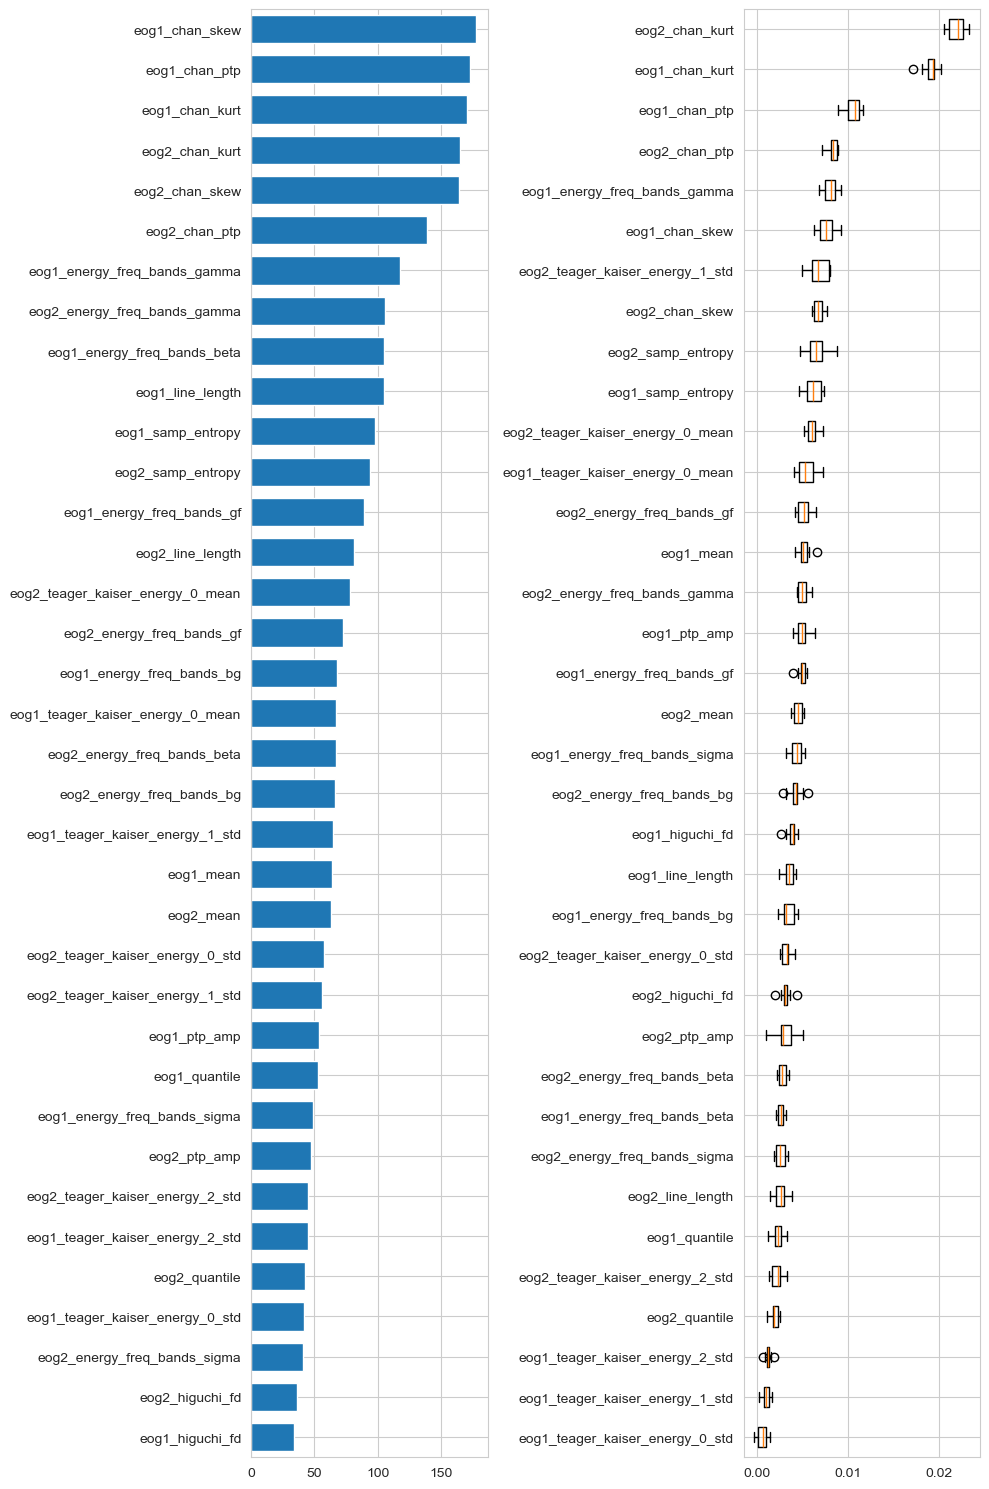

In [393]:
# permutation importance
from sklearn.inspection import permutation_importance
result = permutation_importance(model, x_test_fold, y_test_fold, n_repeats=10, random_state=8, n_jobs=2)
perm_sorted_idx = result.importances_mean.argsort()
tree_importance_sorted_idx = np.argsort(model.feature_importances_)
tree_indices = np.arange(0, len(model.feature_importances_)) + 0.5
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 15))
ax1.barh(tree_indices, model.feature_importances_[tree_importance_sorted_idx], height=0.7)
ax1.set_yticklabels(x_test_fold.columns[tree_importance_sorted_idx])
ax1.set_yticks(tree_indices)
ax1.set_ylim((0, len(model.feature_importances_)))
ax2.boxplot(result.importances[perm_sorted_idx].T, vert=False, labels=x_test_fold.columns[perm_sorted_idx])
fig.tight_layout()
plt.show()

In [22]:
# Extract the mean and standard deviation of the permutation importances
perm_importance_mean = result.importances_mean
perm_importance_std = result.importances_std
feature_names = x_test_fold.columns

# Create a DataFrame
perm_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance_Mean': perm_importance_mean,
    'Importance_Std': perm_importance_std
})

# Sort by importance mean
perm_importance_df = perm_importance_df.sort_values(by='Importance_Mean', ascending=False)

# Save to CSV
perm_importance_df.to_csv('permutation_importance_results.csv', index=False)

In [355]:
plt.figure(figsize=(8,8))
pai = x[y==1]['subj'].value_counts()
plt.pie(x=pai, labels=pai.index, startangle=30, autopct='%1.2f%%', pctdistance=0.80, explode=[0.05] * len(pai))
### Add a hole in the pie  
hole = plt.Circle((0, 0), 0.65, facecolor='white')
plt.gcf().gca().add_artist(hole)

KeyError: 'subj'

<Figure size 800x800 with 0 Axes>

In [31]:
x[x['subj'] == '025']

,subj,eog1_epoch_id,eog1_app_entropy,eog1_decorr_time,eog1_energy_freq_bands_theta,eog1_energy_freq_bands_alpha,eog1_energy_freq_bands_sigma,eog1_energy_freq_bands_beta,eog1_energy_freq_bands_gamma,eog1_energy_freq_bands_fast,...,eog2_energy_freq_bands_st,eog2_energy_freq_bands_sg,eog2_energy_freq_bands_sf,eog2_energy_freq_bands_gt,eog2_energy_freq_bands_gf,eog2_energy_freq_bands_ft,eog2_chan_name,eog2_chan_ptp,eog2_chan_skew,eog2_chan_kurt
6000,025,74358,0.114444,-1.000,0.259685,0.009663,0.023394,0.078648,0.025478,0.002624,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6001,025,89798,0.109050,0.037,0.101114,0.127873,0.043052,0.064266,0.061337,0.002904,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6002,025,32743,0.115349,-1.000,0.237513,0.325202,0.091924,0.125625,0.048809,0.002522,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6003,025,32902,0.073304,-1.000,0.484418,0.667420,0.097008,0.091827,0.048066,0.004369,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6004,025,74027,0.077945,0.037,0.091789,0.060968,0.023774,0.095241,0.049058,0.003048,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28603,025,3294,0.231944,0.041,0.065506,0.119948,0.135136,0.130295,0.145839,0.003147,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
28604,025,64472,0.129608,0.037,0.109971,0.041539,0.010605,0.033096,0.053188,0.002606,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
28605,025,35844,0.046664,-1.000,0.189956,0.279962,0.078850,0.095197,0.020067,0.002482,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
28606,025,115139,0.120340,-1.000,0.026477,0.020320,0.023047,0.076278,0.034662,0.002455,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [357]:
subj = '752'
# model = joblib.load(r'C:\repos\spikes_notebooks\validation_models_v3\lgbm_s50_f36_b_6000max.pkl')
# get models feature names
x.rename(columns={'eog1_subj': 'subj'}, inplace=True)
x_train = x_feat[x['subj'] != subj]
y_train = y[x['subj'] != subj]
x_test = x_feat[x['subj'] == subj]
y_test = y[x['subj'] == subj]
model = LGBMClassifier()
model.fit(x_train, y_train)
y_depth = subj_data[subj]['y']
model_feat = model.feature_name_
subj_feat = pd.concat([subj_data[subj]['eog1'], subj_data[subj]['eog2']], axis=1, ignore_index=True) 
subj_feat.columns = [f'eog1_{col}' for col in subj_data[subj]['eog1'].columns] + [f'eog2_{col}' for col in subj_data[subj]['eog2'].columns]
subj_selected_feat = subj_feat[model_feat]
y_proba = model.predict_proba(subj_selected_feat).T
y_scalp = [p > 0.8 for p in y_proba[1]]
index_map = map_nan_index('C:\\clean_zeeg\\P%s_mtl_clean.fif' % subj)
#some problem with empty y_scalp
scalp_indexes = np.where(np.array(y_scalp) == True)[0]
scalp_onsets = [index_map[int(x)] / 4 for x in scalp_indexes]
depth_indexes = np.where(y_depth == 1)[0]
depth_onsets = [index_map[int(x)] / 4 for x in depth_indexes]
both = [x for x in scalp_onsets if x in depth_onsets]
depth_without_both = [x for x in depth_onsets if x not in both]
scalp_without_both = [x for x in scalp_onsets if x not in both]
raw = mne.io.read_raw('C:\\clean_zeeg\\P%s_mtl_clean.fif' % subj)
print(sum(y_scalp), sum(y_depth), len(both))
# all annot
annot = mne.Annotations(scalp_without_both, [0.25] * len(scalp_without_both), ['scalp'] * len(scalp_without_both)).append(depth_without_both, [0.25] * len(depth_without_both), ['depth'] * len(depth_without_both)).append(both, [0.25] * len(both), ['both'] * len(both))
# only depth and both
# annot = mne.Annotations(depth_onsets, [0.25] * len(depth_onsets), ['depth'] * len(depth_onsets)).append(both, [0.25] * len(both), ['both'] * len(both))
# only both
# annot = mne.Annotations(both, [0.25] * len(both), ['both'] * len(both))
raw.set_annotations(annot)
# mne.set_bipolar_reference(raw, raw.ch_names[0], raw.ch_names[1], ch_name='bi', drop_refs=False).plot(
#     duration=30, scalings='auto')

raw.crop(tmin=0, tmax=60*60*3).plot(duration=30, scalings='auto')

[LightGBM] [Info] Number of positive: 140104, number of negative: 140104
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.022132 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8142
[LightGBM] [Info] Number of data points in the train set: 280208, number of used features: 36
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
Opening raw data file C:\clean_zeeg\P752_mtl_clean.fif...


This filename (C:\clean_zeeg\P752_mtl_clean.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz


Isotrak not found
    Range : 25504000 ... 49110000 =  25504.000 ... 49110.000 secs
Ready.
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Setting 503395 of 23606001 (2.13%) samples to NaN, retaining 23102606 (97.87%) samples.
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
n

This filename (C:\clean_zeeg\P752_mtl_clean.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz


    Range : 25504000 ... 49110000 =  25504.000 ... 49110.000 secs
Ready.
4654 3281 1230


In [354]:
x

,eog1_subj,eog1_epoch_id,eog1_app_entropy,eog1_decorr_time,eog1_energy_freq_bands_theta,eog1_energy_freq_bands_alpha,eog1_energy_freq_bands_sigma,eog1_energy_freq_bands_beta,eog1_energy_freq_bands_gamma,eog1_energy_freq_bands_fast,...,eog2_energy_freq_bands_st,eog2_energy_freq_bands_sg,eog2_energy_freq_bands_sf,eog2_energy_freq_bands_gt,eog2_energy_freq_bands_gf,eog2_energy_freq_bands_ft,eog2_chan_name,eog2_chan_ptp,eog2_chan_skew,eog2_chan_kurt
0,013,59494,0.129083,-1.000,0.600729,1.069837,1.843881,0.644323,0.067834,0.001486,...,5.553981,17.117715,357.734478,0.324458,20.898495,0.015525,EOG2,42.421705,-0.435746,18.247598
1,013,62728,0.086768,-1.000,0.036895,0.223648,0.945054,0.715200,0.066430,0.004593,...,6.330299,3.037991,844.824529,2.083712,278.086589,0.007493,EOG1,56.238462,-0.031135,11.269391
2,013,51457,0.272832,-1.000,0.055827,0.318945,0.259579,0.929908,0.240906,0.002576,...,2.632472,1.984866,33.880880,1.326272,17.069605,0.077698,EOG2,42.421705,-0.435746,18.247598
3,013,15829,0.115442,0.041,0.420092,1.647496,0.528142,0.153927,0.153231,0.002798,...,5.948514,10.277092,157.784805,0.578813,15.353059,0.037700,EOG2,42.421705,-0.435746,18.247598
4,013,15339,0.155859,0.038,0.695643,0.998246,0.621330,0.714989,0.068186,0.004202,...,1.388014,7.224875,283.499621,0.192116,39.239379,0.004896,EOG1,56.238462,-0.031135,11.269391
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
292203,818,77506,0.921053,0.017,0.014177,0.003955,0.002064,0.013709,0.044740,0.128793,...,0.145567,0.046127,0.016024,3.155746,0.347376,9.084518,EOG,66.780052,-2.357676,62.573109
292204,818,79199,0.684866,-1.000,0.003675,0.002048,0.001830,0.001965,0.032966,0.093978,...,0.498021,0.055513,0.019473,8.971183,0.350788,25.574380,EOG,66.780052,-2.357676,62.573109
292205,818,23187,0.468069,0.038,0.008318,0.008131,0.019911,0.024853,0.090774,0.120664,...,2.393671,0.219343,0.165009,10.912908,0.752289,14.506264,EOG,66.780052,-2.357676,62.573109
292206,818,28556,0.871787,0.048,0.004333,0.003671,0.002644,0.004003,0.039706,0.078606,...,0.610143,0.066590,0.033636,9.162652,0.505122,18.139485,EOG,66.780052,-2.357676,62.573109


In [52]:
y_scalp.shape

AttributeError: 'list' object has no attribute 'shape'

In [262]:
scalp_indexes

array([], dtype=int64)

In [219]:
all_results = pd.DataFrame()

# combine all subjects
for subj in [x for x in all_subjects if x not in less_10]:
    x = pd.DataFrame()
    y = np.array([])
    print(f'Processing {subj}')
    eog1_subj = subj_data[subj]['eog1']
    eog2_subj = subj_data[subj]['eog2']
    y_subj = subj_data[subj]['y']
    eog1_subj.reset_index(drop=True, inplace=True)
    eog2_subj.reset_index(drop=True, inplace=True)
    x_subj = pd.concat([eog1_subj, eog2_subj], axis=1, ignore_index=True)
    x_subj.columns = [f'eog1_{col}' for col in eog1_subj.columns] + [f'eog2_{col}' for col in eog2_subj.columns]
    # undersample
    rus = RandomUnderSampler(random_state=8)
    x, y = rus.fit_resample(x_subj, y_subj)
    meta_data = ['subj', 'epoch_id', 'chan_name', 'epoch']
    x_feat = x[x.columns[~x.columns.str.contains('|'.join(meta_data))]]
    # save model results
    metrics = {'accuracy': [], 'precision': [], 'sensitivity': [], 'specificity': [],'f1': [], 'ROCAUC': [], 'PRAUC': []}
    kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=8)
    for train_index, test_index in kf.split(x_feat, y):
        # model = xgb.XGBClassifier()
        model = LGBMClassifier()
        # model = RandomForestClassifier()
        x_train_fold, x_test_fold = x_feat.iloc[train_index], x_feat.iloc[test_index]
        y_train_fold, y_test_fold = y[train_index], y[test_index]
        model.fit(x_train_fold, y_train_fold)
        y_pred = model.predict(x_test_fold)
        y_true = y_test_fold
        # save scores in dict
        metrics['accuracy'].append(accuracy_score(y_true, y_pred))
        metrics['precision'].append(precision_score(y_true, y_pred))
        metrics['sensitivity'].append(recall_score(y_true, y_pred))
        metrics['f1'].append(f1_score(y_true, y_pred))
        tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
        metrics['specificity'].append(tn / (tn + fp))
        metrics['ROCAUC'].append(roc_auc_score(y_true, y_pred))
        metrics['PRAUC'].append(average_precision_score(y_true, y_pred))
    
    # print results as df
    results = pd.DataFrame(metrics)
    results.loc['mean'] = results.mean()
    # Add subject ID and prepare for concatenation
    mean_row = results.loc['mean'].to_dict()  # Convert mean row to a dictionary
    mean_row['subject_id'] = subj  # Add the subject ID
    mean_row_df = pd.DataFrame([mean_row])  # Create a DataFrame from the dictionary
    
    # Concatenate to all_results
    all_results = pd.concat([all_results, mean_row_df], ignore_index=True)
    # Set the order of columns in all_results (optional)
    all_results = all_results[['subject_id'] + [col for col in all_results.columns if col != 'subject_id']]

Processing 013
[LightGBM] [Info] Number of positive: 688, number of negative: 688
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004069 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 51116
[LightGBM] [Info] Number of data points in the train set: 1376, number of used features: 204
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Number of positive: 688, number of negative: 688
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003168 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 51117
[LightGBM] [Info] Number of data points in the train set: 1376, number of used features: 204
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Number of positive: 688, number of negative: 688
[LightGBM] [Info] Auto-choosing col-wise multi

In [220]:
all_results

,subject_id,accuracy,precision,sensitivity,specificity,f1,ROCAUC,PRAUC
0,013,0.693605,0.695805,0.690698,0.696512,0.692036,0.693605,0.634867
1,017,0.760337,0.750142,0.780069,0.740615,0.764548,0.760342,0.695514
2,018,0.574000,0.577807,0.580769,0.561538,0.574734,0.571154,0.562185
3,38,0.600659,0.604840,0.586006,0.615211,0.594807,0.600608,0.561970
4,39,0.511850,0.511736,0.498819,0.524821,0.504970,0.511820,0.506274
5,44,0.667115,0.657219,0.698472,0.635745,0.677073,0.667108,0.610298
6,47,0.572065,0.564881,0.615789,0.528421,0.586525,0.572105,0.548142
7,48,0.689706,0.689618,0.694118,0.685294,0.691262,0.689706,0.631486
8,51,0.830098,0.839842,0.817937,0.842324,0.828017,0.830131,0.777596
9,53,0.735810,0.728842,0.752958,0.718656,0.739853,0.735807,0.671929


In [221]:
# get mean of each col
all_results.iloc[:, 1:].mean()

accuracy       0.653196
precision      0.660980
sensitivity    0.644030
specificity    0.662250
f1             0.650931
ROCAUC         0.653140
PRAUC          0.612892
dtype: float64

In [222]:
all_results.shape

(46, 8)

In [215]:
all_results.iloc[16:36, 1:].mean()

accuracy       0.685658
precision      0.697504
sensitivity    0.663413
specificity    0.707903
f1             0.677218
ROCAUC         0.685658
PRAUC          0.631491
dtype: float64

In [358]:
# raw data metrics
metrics = {'accuracy': [], 'precision': [], 'sensitivity': [], 'specificity': [],'f1': [], 'ROCAUC': [], 'PRAUC': []}
for subj in clean_subjects:
    print(f'Processing {subj}')
    x_train = x_feat[x['subj'] != subj]
    y_train = y[x['subj'] != subj]
    x_test = x_feat[x['subj'] == subj]
    y_test = y[x['subj'] == subj]
    model = LGBMClassifier()
    model.fit(x_train, y_train)
    y_depth = subj_data[subj]['y']
    model_feat = model.feature_name_
    subj_feat = pd.concat([subj_data[subj]['eog1'], subj_data[subj]['eog2']], axis=1, ignore_index=True) 
    subj_feat.columns = [f'eog1_{col}' for col in subj_data[subj]['eog1'].columns] + [f'eog2_{col}' for col in subj_data[subj]['eog2'].columns]
    subj_selected_feat = subj_feat[model_feat]
    y_proba = model.predict_proba(subj_selected_feat).T
    y_scalp = [p > 0.8 for p in y_proba[1]]
    index_map = map_nan_index('C:\\clean_zeeg\\P%s_mtl_clean.fif' % subj)
    #some problem with empty y_scalp
    scalp_indexes = np.where(np.array(y_scalp) == True)[0]
    scalp_onsets = [index_map[int(x)] / 4 for x in scalp_indexes]
    depth_indexes = np.where(y_depth == 1)[0]
    depth_onsets = [index_map[int(x)] / 4 for x in depth_indexes]
    both = [x for x in scalp_onsets if x in depth_onsets]
    depth_without_both = [x for x in depth_onsets if x not in both]
    scalp_without_both = [x for x in scalp_onsets if x not in both]
    print(sum(y_scalp), sum(y_depth), len(both))
    y_true = y_depth
    y_pred = y_scalp
    metrics['accuracy'].append(accuracy_score(y_true, y_pred))
    metrics['precision'].append(precision_score(y_true, y_pred))
    metrics['sensitivity'].append(recall_score(y_true, y_pred))
    metrics['f1'].append(f1_score(y_true, y_pred))
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    metrics['specificity'].append(tn / (tn + fp))
    metrics['ROCAUC'].append(roc_auc_score(y_true, y_pred))
    metrics['PRAUC'].append(average_precision_score(y_true, y_pred))

# print results as df
results = pd.DataFrame(metrics)
# add mean row
results.loc['mean'] = results.mean()
results

Processing 013
[LightGBM] [Info] Number of positive: 144384, number of negative: 144384
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.056773 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8142
[LightGBM] [Info] Number of data points in the train set: 288768, number of used features: 36
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
Opening raw data file C:\clean_zeeg\P013_mtl_clean.fif...


This filename (C:\clean_zeeg\P013_mtl_clean.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz


Isotrak not found
    Range : 0 ... 30161999 =      0.000 ... 30161.999 secs
Ready.
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Setting 2929940 of 30162000 (9.71%) samples to NaN, retaining 27232060 (90.29%) samples.
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan

This filename (C:\clean_zeeg\P017_mtl_clean.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz


Isotrak not found
    Range : 0 ... 38765999 =      0.000 ... 38765.999 secs
Ready.
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Setting 4226006 of 38766000 (10.90%) samples to NaN, retaining 34539994 (89.10%) samples.
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
na

This filename (C:\clean_zeeg\P018_mtl_clean.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz


Isotrak not found
    Range : 0 ... 5344999 =      0.000 ...  5344.999 secs
Ready.
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Setting 1494674 of 5345000 (27.96%) samples to NaN, retaining 3850326 (72.04%) samples.
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
n

This filename (C:\clean_zeeg\P025_mtl_clean.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz


    Range : 0 ... 32258999 =      0.000 ... 32258.999 secs
Ready.
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Setting 2965949 of 32259000 (9.19%) samples to NaN, retaining 29293051 (90.81%) samples.
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
n

This filename (C:\clean_zeeg\P38_mtl_clean.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz


Isotrak not found
    Range : 0 ... 19870999 =      0.000 ... 19870.999 secs
Ready.
Opening raw data file C:\clean_zeeg\P38_mtl_clean-1.fif...
Isotrak not found
    Range : 19871000 ... 37044999 =  19871.000 ... 37044.999 secs
Ready.
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Setting 1787181 of 37045000 (4.82%) samples to NaN, retaining 35257819 (95.18%) samples.
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
n

This filename (C:\clean_zeeg\P39_mtl_clean.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz


Isotrak not found
    Range : 0 ... 18547999 =      0.000 ... 18547.999 secs
Ready.
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Setting 2378228 of 18548000 (12.82%) samples to NaN, retaining 16169772 (87.18%) samples.
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
na

This filename (C:\clean_zeeg\P44_mtl_clean.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz


Isotrak not found
    Range : 0 ... 31556999 =      0.000 ... 31556.999 secs
Ready.
Opening raw data file C:\clean_zeeg\P44_mtl_clean-1.fif...
Isotrak not found
    Range : 31557000 ... 40141999 =  31557.000 ... 40141.999 secs
Ready.
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Setting 6065761 of 40142000 (15.11%) samples to NaN, retaining 34076239 (84.89%) samples.
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan


This filename (C:\clean_zeeg\P46_mtl_clean.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz


Isotrak not found
    Range : 0 ... 36135999 =      0.000 ... 36135.999 secs
Ready.
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Setting 5851349 of 36136000 (16.19%) samples to NaN, retaining 30284651 (83.81%) samples.
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
na

This filename (C:\clean_zeeg\P47_mtl_clean.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz


Isotrak not found
    Range : 0 ... 24385999 =      0.000 ... 24385.999 secs
Ready.
Opening raw data file C:\clean_zeeg\P47_mtl_clean-1.fif...
Isotrak not found
    Range : 24386000 ... 35360999 =  24386.000 ... 35360.999 secs
Ready.
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Setting 3267661 of 35361000 (9.24%) samples to NaN, retaining 32093339 (90.76%) samples.
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
n

This filename (C:\clean_zeeg\P48_mtl_clean.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz


Isotrak not found
    Range : 0 ... 23520000 =      0.000 ... 23520.000 secs
Ready.
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Setting 2154478 of 23520001 (9.16%) samples to NaN, retaining 21365523 (90.84%) samples.
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan

This filename (C:\clean_zeeg\P49_mtl_clean.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz


Isotrak not found
    Range : 0 ... 5699999 =      0.000 ...  5699.999 secs
Ready.
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Setting 254814 of 5700000 (4.47%) samples to NaN, retaining 5445186 (95.53%) samples.
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan

This filename (C:\clean_zeeg\P51_mtl_clean.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz


Isotrak not found
    Range : 0 ... 31800000 =      0.000 ... 31800.000 secs
Ready.
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Setting 1161112 of 31800001 (3.65%) samples to NaN, retaining 30638889 (96.35%) samples.
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan

This filename (C:\clean_zeeg\P53_mtl_clean.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz


Isotrak not found
    Range : 0 ... 26126999 =      0.000 ... 26126.999 secs
Ready.
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Setting 4582759 of 26127000 (17.54%) samples to NaN, retaining 21544241 (82.46%) samples.
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
na

This filename (C:\clean_zeeg\P54_mtl_clean.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
Invalid tag with only 0/16 bytes at position 1606078250 in file C:\clean_zeeg\P54_mtl_clean.fif


nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan


invalid value encountered in cast


IndexError: list index out of range

In [360]:
# print results as df
results = pd.DataFrame(metrics)
# add mean row
results.loc['mean'] = results.mean()
results

,accuracy,precision,sensitivity,specificity,f1,ROCAUC,PRAUC
0,0.958852,0.030610,0.137209,0.965396,0.050053,0.551302,0.011017
1,0.957249,0.041675,0.206767,0.963077,0.069368,0.584922,0.014729
2,0.796297,0.001944,0.096774,0.799126,0.003812,0.447950,0.003826
3,0.983107,0.000000,0.000000,0.983124,0.000000,0.491562,0.000017
4,0.984013,0.026149,0.031191,0.991217,0.028448,0.511204,0.008086
5,0.982263,0.007576,0.002257,0.995889,0.003478,0.499073,0.013699
6,0.991270,0.000000,0.000000,0.999578,0.000000,0.499789,0.008311
7,0.990959,0.000000,0.000000,0.991016,0.000000,0.495508,0.000058
8,0.999158,0.000000,0.000000,0.999914,0.000000,0.499957,0.000756
9,0.995902,0.142857,0.005882,0.999859,0.011299,0.502871,0.004797
